# Chp 12: Part 3

## 12.3 Neural style transfer

**Getting the style and content images**

950272/943128 [==============================] - 0s 0us/step


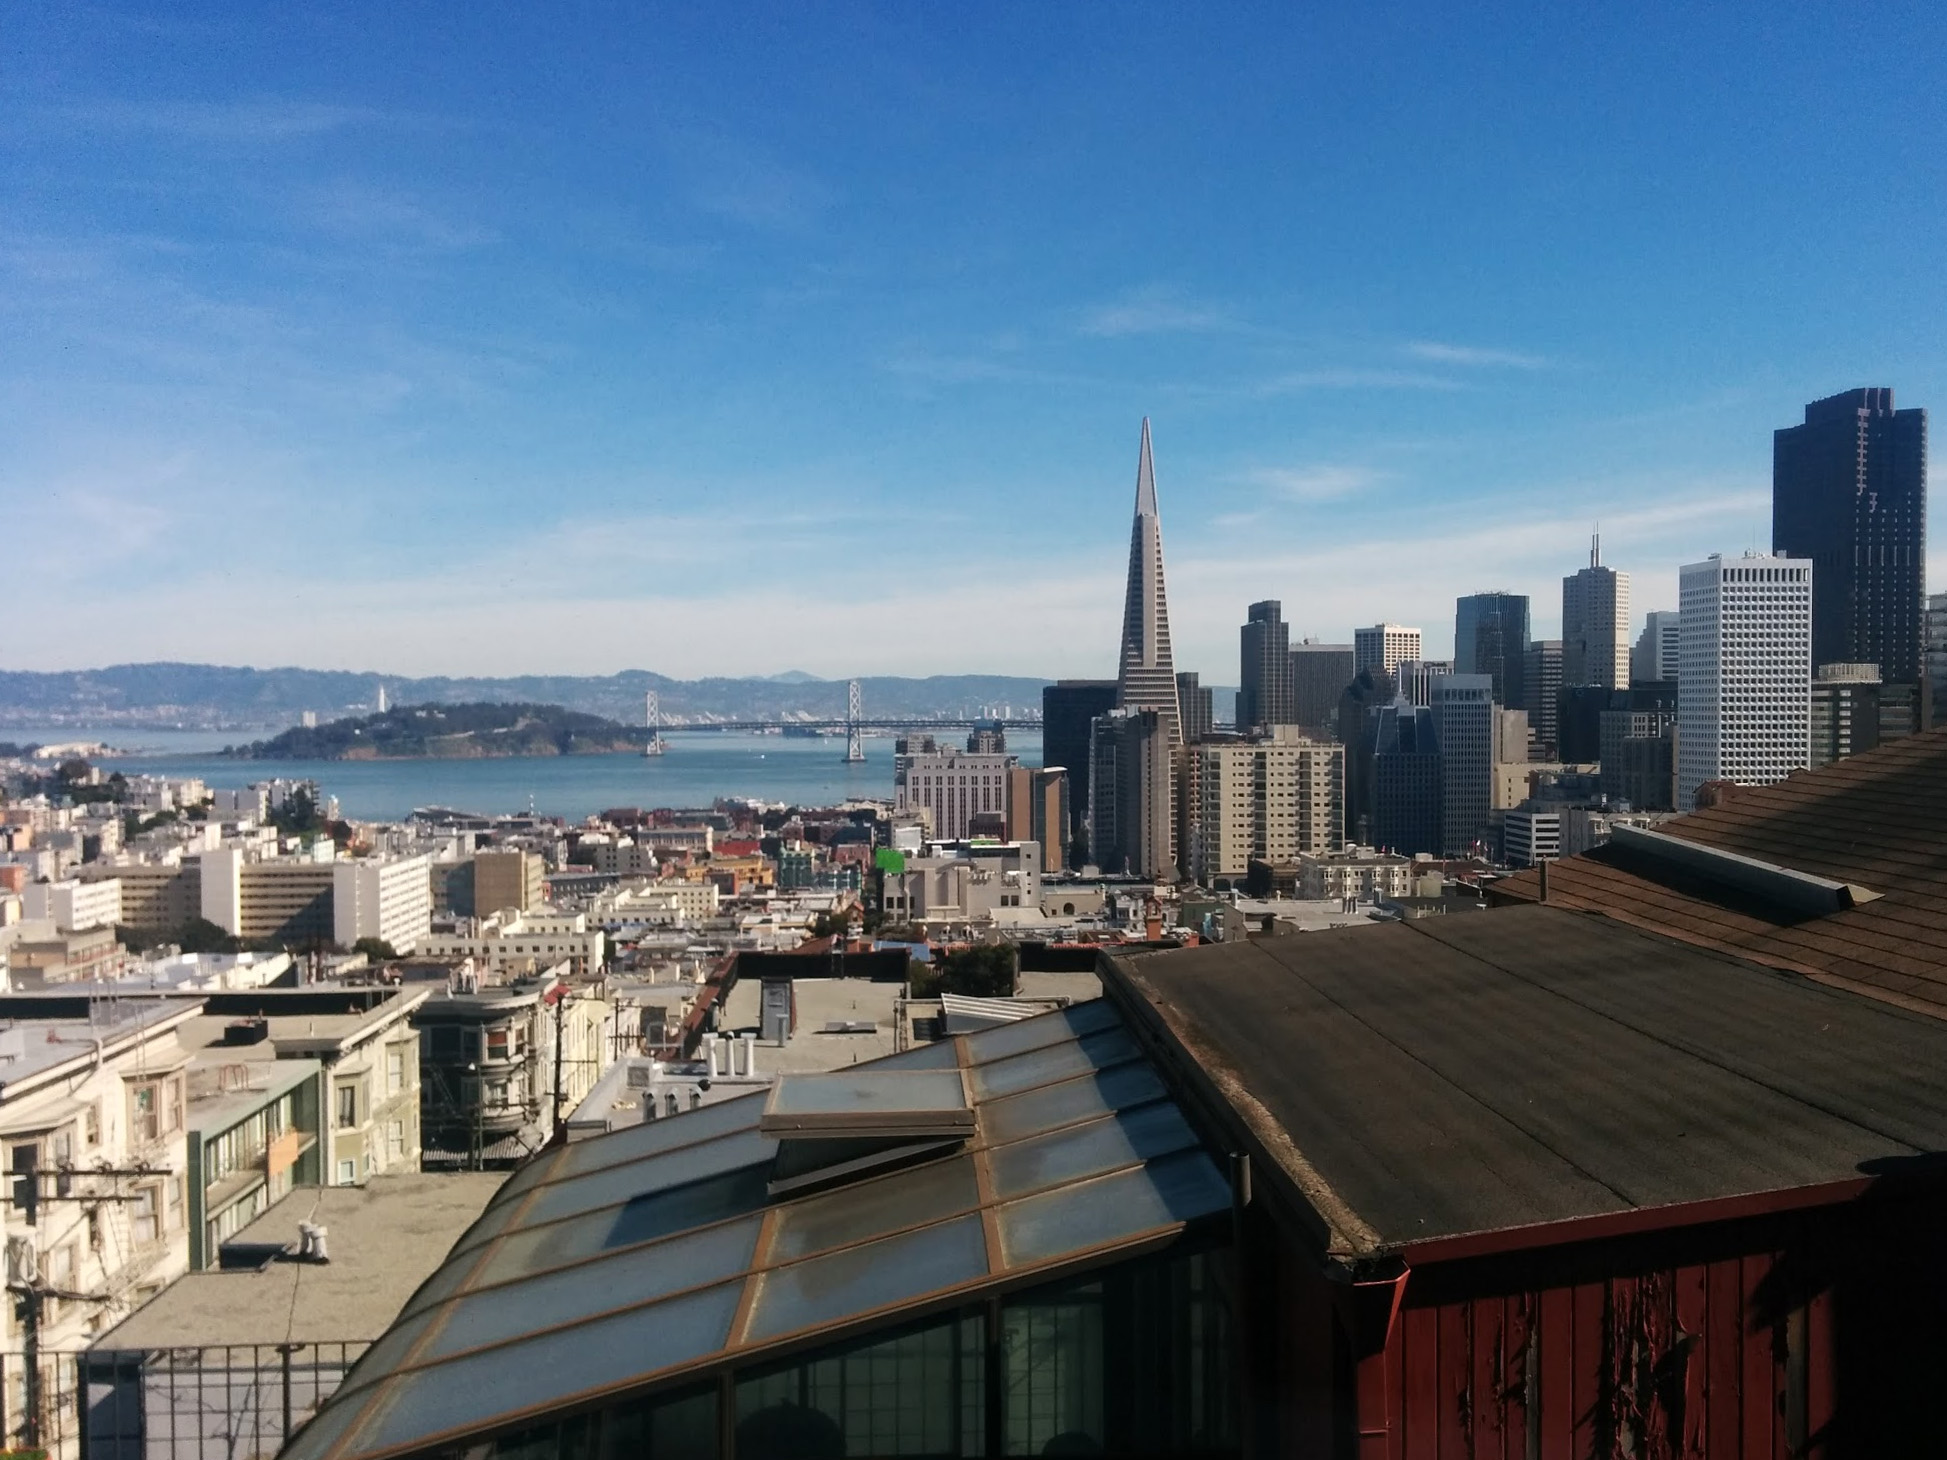

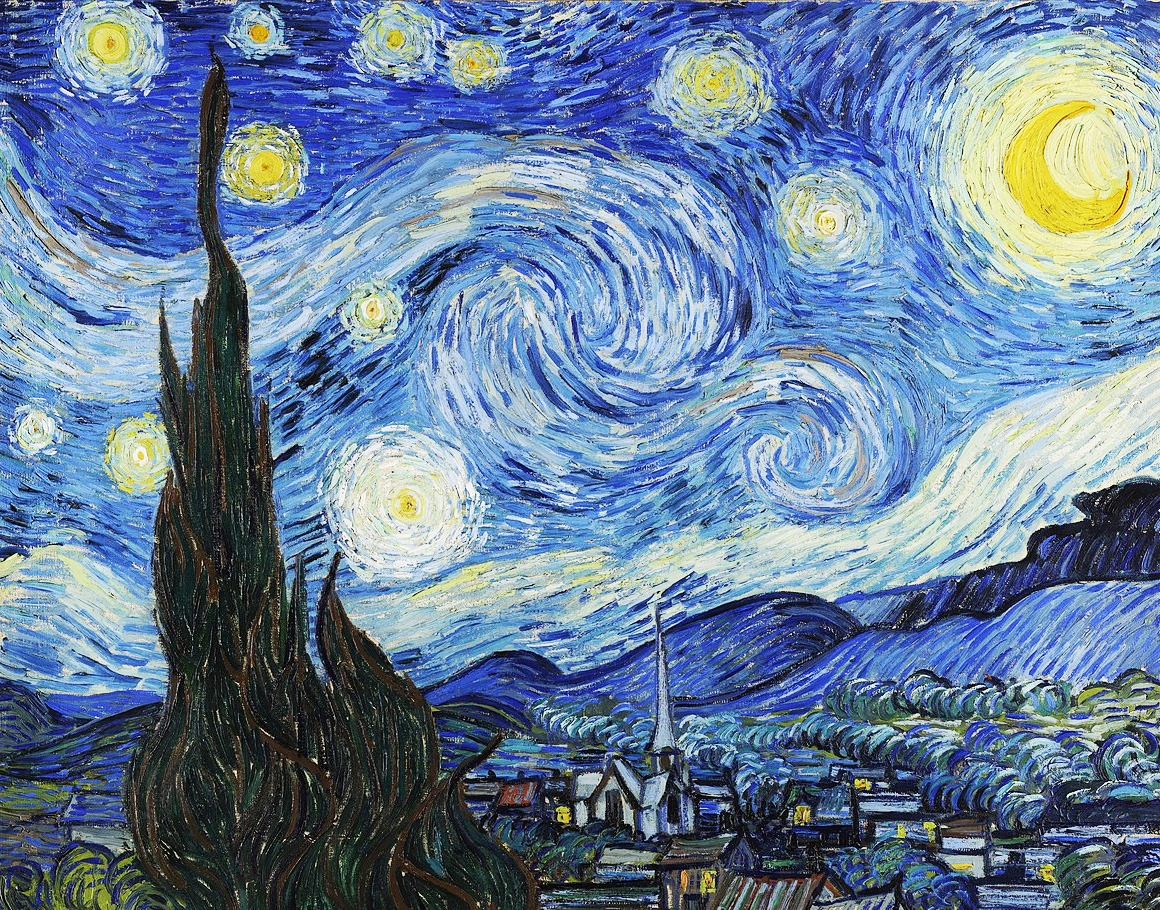

In [1]:
# Listing 12.9 Getting the style and content images

def listing12_9():
    import tensorflow as tf
    from tensorflow import keras

    base_image_path = keras.utils.get_file(
        "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
    style_reference_image_path = keras.utils.get_file(
        "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

    original_width, original_height = tf.keras.preprocessing.image.load_img(base_image_path).size
    img_height = 400
    img_width = round(original_width * img_height / original_height)

    from IPython.display import Image
    display(Image(base_image_path))
    display(Image(style_reference_image_path))

    return base_image_path, style_reference_image_path, img_height, img_width

base_image_path, style_reference_image_path, img_height, img_width = listing12_9()

**Auxiliary functions**

In [2]:
# Listing 12.10 Auxiliary functions
# Auxiliary functions for loading, preprocessing, and postprocessing the 
# images that go in and out of the VGG19 convnet.

import numpy as np

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img


**Loading the pretrained VGG19 network and using it to define a feature extractor**

In [3]:
# Listing 12.11 Loading the pretrained VGG19 network and using it to define a feature extractor
def listing12_11():
    from tensorflow import keras

    model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)
    
    return feature_extractor

feature_extractor = listing12_11()

80142336/80134624 [==============================] - 0s 0us/step


In [4]:
# Content loss
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [5]:
# Style loss
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [6]:
# Total variation loss
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [7]:
# Defining the final loss that you'll minimize
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [8]:
# Setting up the gradient-descent process
import tensorflow as tf
from tensorflow import keras

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

#iterations = 4000
iterations = 400
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        tf.keras.preprocessing.image.save_img(fname, img)


print("\nDone..")

Iteration 100: loss=8136.23
Iteration 200: loss=6651.98
Iteration 300: loss=6062.23
Iteration 400: loss=5741.55

Done..


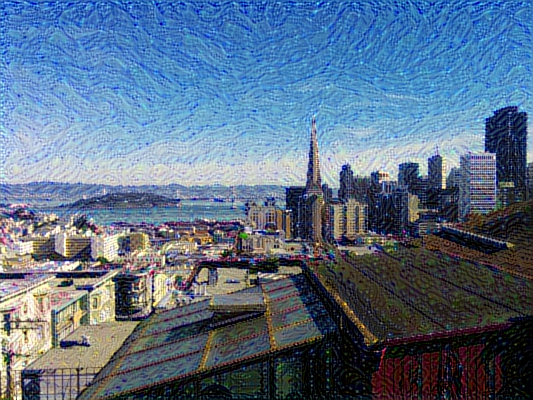

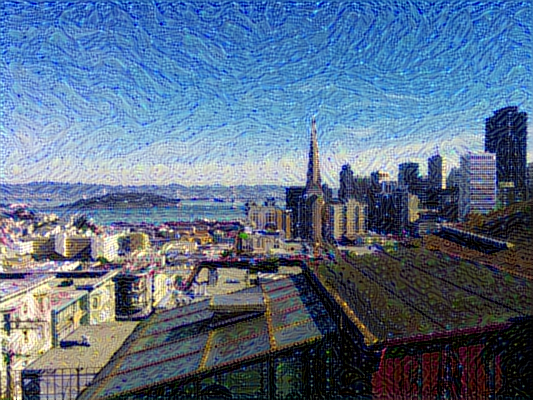

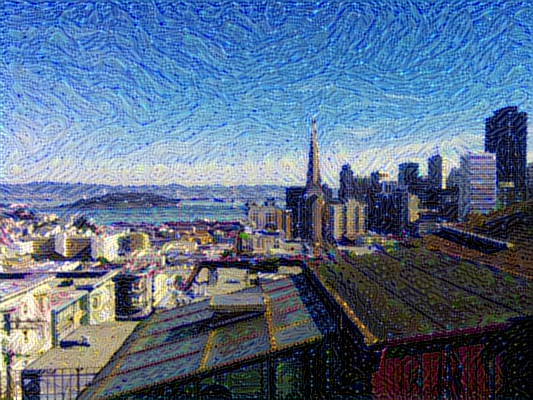

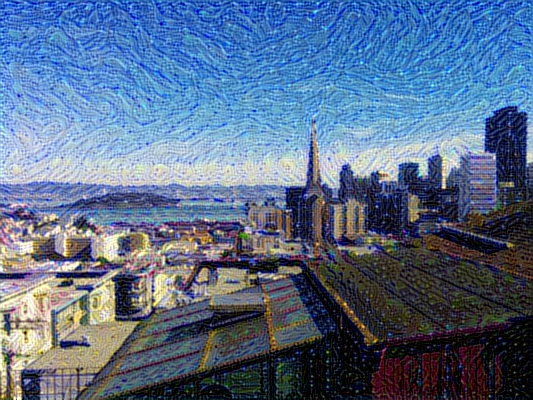

In [10]:
from IPython.display import Image
display(Image("combination_image_at_iteration_100.png"))
display(Image("combination_image_at_iteration_200.png"))
display(Image("combination_image_at_iteration_300.png"))
display(Image("combination_image_at_iteration_400.png"))
    